<a href="https://colab.research.google.com/github/arvindsuresh-math/Fall-2025-Team-Big-Data/blob/main/Naive_NN_for_AirBNB_NYC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [36]:
! [ -e /content ] && pip install -Uqq fastbook kaggle waterfallcharts treeinterpreter dtreeviz==1.4.1
import fastbook
fastbook.setup_book()

In [37]:
from fastbook import *
from fastai.vision.all import *
from fastai.text.all import *
from fastai.collab import *
from fastai.tabular.all import *
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from fastai.tabular.all import *
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from dtreeviz.trees import *
from IPython.display import Image, display_svg, SVG

In [38]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [39]:
df_nn = pd.read_csv('/content/gdrive/MyDrive/listings.csv', low_memory=False)
# Drop rows where 'price' is NaN
df_nn.dropna(subset=['price'], inplace=True)
# Drop rows where 'reviews_per_month' is NaN
df_nn.dropna(subset=['reviews_per_month'], inplace=True)


#unique_values = df_nn['host_id'].unique()
#print(len(unique_values), len(df_nn['host_id']))

In [40]:
# Dropping 'name' column cause it's cardinality is close to length of the column **split 'name' by keywords at some point?
df_nn.drop('name', axis=1, inplace=True)
# Dropping 'id' column cause it's cardinality is same as it's length
df_nn.drop('id', axis=1, inplace=True)

In [41]:
pd.options.display.max_columns = None
df_nn = add_datepart(df_nn, 'last_review')
df_nn.head(13)

,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,license,last_reviewYear,last_reviewMonth,last_reviewWeek,last_reviewDay,last_reviewDayofweek,last_reviewDayofyear,last_reviewIs_month_end,last_reviewIs_month_start,last_reviewIs_quarter_end,last_reviewIs_quarter_start,last_reviewIs_year_end,last_reviewIs_year_start,last_reviewElapsed
0,2787,John,Brooklyn,Kensington,40.645290,-73.972380,Private room,260.0,30,9,0.08,6,365,0,NaN,2018,10,42,19,4,292,False,False,False,False,False,False,1.539907e+09
1,2845,Jennifer,Manhattan,Midtown,40.753560,-73.985590,Entire home/apt,240.0,30,47,0.25,3,365,0,NaN,2022,6,25,21,1,172,False,False,False,False,False,False,1.655770e+09
2,15991,Allen,Brooklyn,Williamsburg,40.709350,-73.953420,Entire home/apt,98.0,30,195,0.99,1,1,3,NaN,2025,6,24,9,0,160,False,False,False,False,False,False,1.749427e+09
4,16800,Cynthia,Manhattan,East Harlem,40.787780,-73.947590,Private room,74.0,30,249,1.30,1,288,6,NaN,2025,5,22,27,1,147,False,False,False,False,False,False,1.748304e+09
6,17571,Jane,Brooklyn,Fort Greene,40.691940,-73.973890,Private room,214.0,2,416,2.20,2,8,38,OSE-STRREG-0000008,2025,7,30,21,0,202,False,False,False,False,False,False,1.753056e+09
7,21207,Chaya,Brooklyn,Williamsburg,40.718807,-73.956177,Entire home/apt,345.0,30,12,0.06,1,0,0,NaN,2024,7,31,31,2,213,True,False,False,False,False,False,1.722384e+09
8,25183,Nathalie,Brooklyn,Bedford-Stuyvesant,40.684556,-73.939634,Entire home/apt,170.0,30,189,0.97,2,246,0,NaN,2023,10,42,16,0,289,False,False,False,False,False,False,1.697414e+09
9,30193,Tommi Laurelle,Manhattan,Hell's Kitchen,40.767240,-73.986640,Entire home/apt,175.0,30,58,0.30,1,57,0,NaN,2017,8,32,13,6,225,False,False,False,False,False,False,1.502582e+09
10,35935,Angela,Brooklyn,Bedford-Stuyvesant,40.682940,-73.956820,Private room,90.0,30,82,0.44,6,183,2,NaN,2025,3,14,31,0,90,True,False,True,False,False,False,1.743379e+09
13,50148,Adreinne,Brooklyn,Bedford-Stuyvesant,40.679460,-73.954170,Entire home/apt,153.0,30,80,0.42,1,327,4,NaN,2025,5,22,31,5,151,True,False,False,False,False,False,1.748650e+09


In [42]:
dep_var = 'price'
cont_nn, cat_nn = cont_cat_split(df_nn, max_card=9000, dep_var=dep_var)

In [108]:
df_nn[cat_nn].nunique()

,0
host_id,8496
host_name,4416
neighbourhood_group,5
neighbourhood,219
room_type,4
license,1806
last_reviewIs_month_end,2
last_reviewIs_month_start,2
last_reviewIs_quarter_end,2
last_reviewIs_quarter_start,2


In [109]:
df_nn[cont_nn].nunique()

,0
latitude,11889
longitude,11472
reviews_per_month,781
last_reviewElapsed,1774
minimum_nights,56
number_of_reviews,482
calculated_host_listings_count,64
availability_365,366
number_of_reviews_ltm,169
last_reviewYear,15


In [45]:
cont_nn.append('minimum_nights')
cont_nn.append('number_of_reviews')
cont_nn.append('calculated_host_listings_count')
cont_nn.append('availability_365')
cont_nn.append('number_of_reviews_ltm')
cont_nn.append('last_reviewYear')
cont_nn.append('last_reviewMonth')
cont_nn.append('last_reviewWeek')
cont_nn.append('last_reviewDay')
cont_nn.append('last_reviewDayofweek')
cont_nn.append('last_reviewDayofyear')

cat_nn.remove('minimum_nights')
cat_nn.remove('number_of_reviews')
cat_nn.remove('calculated_host_listings_count')
cat_nn.remove('availability_365')
cat_nn.remove('number_of_reviews_ltm')
cat_nn.remove('last_reviewYear')
cat_nn.remove('last_reviewMonth')
cat_nn.remove('last_reviewWeek')
cat_nn.remove('last_reviewDay')
cat_nn.remove('last_reviewDayofweek')
cat_nn.remove('last_reviewDayofyear')

In [46]:
cond= (df_nn.last_reviewYear<2025) | (df_nn.last_reviewMonth<5)
train_idx = np.where(cond)[0]
valid_idx = np.where(~cond)[0]
splits = (list(train_idx), list(valid_idx))

In [47]:
procs_nn = [Categorify, FillMissing, Normalize]
to_nn = TabularPandas(df_nn, procs_nn, cat_nn, cont_nn, y_names=dep_var, splits=splits)

In [48]:
dls = to_nn.dataloaders(bs=1024)

In [49]:
y = to_nn.train.y
y.min(),y.max()

(10.0, 50000.0)

In [50]:
learn = tabular_learner(dls, y_range=(y.min(),y.max()), layers=[500,250], n_out=1, loss_func=F.mse_loss)

SuggestedLRs(valley=0.0012022644514217973)

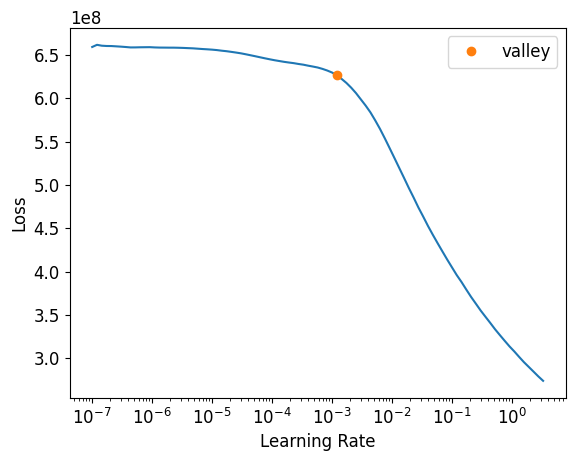

In [51]:
learn.lr_find()

In [52]:
learn.fit_one_cycle(100, 0.001)

epoch,train_loss,valid_loss,time
0,633902656.000000,647944576.000000,00:00
1,623310016.000000,767983232.000000,00:00
2,617048320.000000,973222016.000000,00:00
3,611550592.000000,1295547008.000000,00:00
4,606086016.000000,1488546560.000000,00:00
5,597720640.000000,1613325056.000000,00:00
6,585697856.000000,1667685120.000000,00:00
7,570549952.000000,1703718016.000000,00:00
8,551650496.000000,1684169984.000000,00:00
9,527979360.000000,1694994048.000000,00:00


In [53]:
def r_mse(pred, y): return round(math.sqrt(((pred-y)**2).mean()), 6)

In [54]:
preds, targs = learn.get_preds()
r_mse(preds, targs)

35588.659767

In [55]:
#
#
#
#
#

In [92]:
def rf(xs, y, n_estimators=40, max_samples=10000,max_features=0.5, min_samples_leaf=5, **kwargs):
  return RandomForestRegressor(n_jobs = -1, n_estimators=n_estimators, max_samples = max_samples, max_features = max_features, min_samples_leaf=min_samples_leaf, oob_score=True).fit(xs, y)

In [95]:
def m_rmse(m, xs, y):
  return r_mse(m.predict(xs), y)

In [59]:
df_rf = pd.read_csv('/content/gdrive/MyDrive/listings.csv', low_memory=False)

# Drop rows where 'price' is NaN
df_rf.dropna(subset=['price'], inplace=True)
# Drop rows where 'reviews_per_month' is NaN
df_rf.dropna(subset=['reviews_per_month'], inplace=True)

# Dropping 'name' column cause it's cardinality is close to length of the column **split 'name' by keywords at some point?
df_rf.drop('name', axis=1, inplace=True)
# Dropping 'id' column cause it's cardinality is same as it's length
df_rf.drop('id', axis=1, inplace=True)

In [60]:
df_rf = add_datepart(df_rf, 'last_review')

In [61]:
df_rf.head()

,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,license,last_reviewYear,last_reviewMonth,last_reviewWeek,last_reviewDay,last_reviewDayofweek,last_reviewDayofyear,last_reviewIs_month_end,last_reviewIs_month_start,last_reviewIs_quarter_end,last_reviewIs_quarter_start,last_reviewIs_year_end,last_reviewIs_year_start,last_reviewElapsed
0,2787,John,Brooklyn,Kensington,40.64529,-73.97238,Private room,260.0,30,9,0.08,6,365,0,NaN,2018,10,42,19,4,292,False,False,False,False,False,False,1.539907e+09
1,2845,Jennifer,Manhattan,Midtown,40.75356,-73.98559,Entire home/apt,240.0,30,47,0.25,3,365,0,NaN,2022,6,25,21,1,172,False,False,False,False,False,False,1.655770e+09
2,15991,Allen,Brooklyn,Williamsburg,40.70935,-73.95342,Entire home/apt,98.0,30,195,0.99,1,1,3,NaN,2025,6,24,9,0,160,False,False,False,False,False,False,1.749427e+09
4,16800,Cynthia,Manhattan,East Harlem,40.78778,-73.94759,Private room,74.0,30,249,1.30,1,288,6,NaN,2025,5,22,27,1,147,False,False,False,False,False,False,1.748304e+09
6,17571,Jane,Brooklyn,Fort Greene,40.69194,-73.97389,Private room,214.0,2,416,2.20,2,8,38,OSE-STRREG-0000008,2025,7,30,21,0,202,False,False,False,False,False,False,1.753056e+09


In [81]:
cond= (df_rf.last_reviewYear<2025) | (df_rf.last_reviewMonth<7)
train_idx_rf = np.where(cond)[0]
valid_idx_rf = np.where(~cond)[0]

In [82]:
splits_rf = (list(train_idx_rf), list(valid_idx_rf))

In [83]:
cont_rf, cat_rf = cont_cat_split(df_rf, 1, dep_var='price')

In [84]:
df_rf[cat_rf].nunique()

,0
host_name,4416
neighbourhood_group,5
neighbourhood,219
room_type,4
license,1806
last_reviewIs_month_end,2
last_reviewIs_month_start,2
last_reviewIs_quarter_end,2
last_reviewIs_quarter_start,2
last_reviewIs_year_end,2


In [85]:
df_rf[cont_rf].nunique()

,0
host_id,8496
latitude,11889
longitude,11472
minimum_nights,56
number_of_reviews,482
reviews_per_month,781
calculated_host_listings_count,64
availability_365,366
number_of_reviews_ltm,169
last_reviewYear,15


In [86]:
cat_rf.append('host_id')

cont_rf.remove('host_id')

In [87]:
procs_rf = [Categorify, FillMissing]

In [88]:
to_rf = TabularPandas(df_rf, procs_rf, cat_rf, cont_rf, y_names=dep_var, splits=splits_rf)

In [89]:
len(to_rf.train), len(to_rf.valid)

(11351, 3609)

In [90]:
xs_rf, y_rf = to_rf.train.xs, to_rf.train.y
valid_xs_rf, valid_y_rf = to_rf.valid.xs, to_rf.valid.y

In [93]:
m = rf(xs_rf, y_rf)

In [96]:
m_rmse(m, xs_rf, y_rf), m_rmse(m, valid_xs_rf, valid_y_rf)

(831.299055, 1479.724818)

In [98]:
preds = np.stack([t.predict(valid_xs_rf) for t in m.estimators_])

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWa

In [99]:
r_mse(preds.mean(0), valid_y_rf)

1479.724818

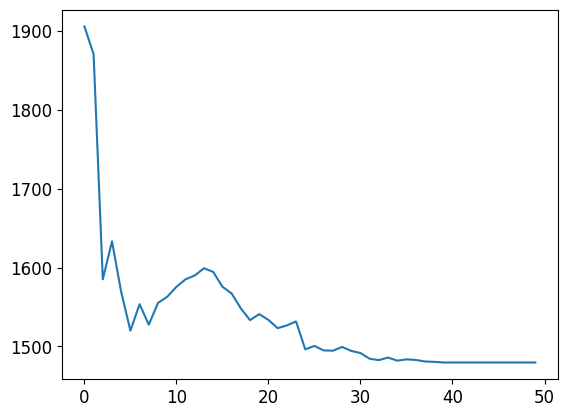

In [101]:
plt.plot([r_mse(preds[:i+1].mean(0), valid_y_rf) for i in range(50)])

In [102]:
r_mse(m.oob_prediction_, y_rf)

1073.733529

In [103]:
def rf_feat_importance(m, df):
  return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                      ).sort_values('imp', ascending=False)

In [104]:
fi = rf_feat_importance(m, xs_rf)
fi[:10]

,cols,imp
17,calculated_host_listings_count,0.393391
11,host_id,0.124455
3,room_type,0.056441
13,longitude,0.050919
18,availability_365,0.049729
12,latitude,0.043391
15,number_of_reviews,0.038061
0,host_name,0.037763
16,reviews_per_month,0.037417
19,number_of_reviews_ltm,0.030400


In [105]:
def plot_fi(fi):
  return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

<Axes: ylabel='cols'>

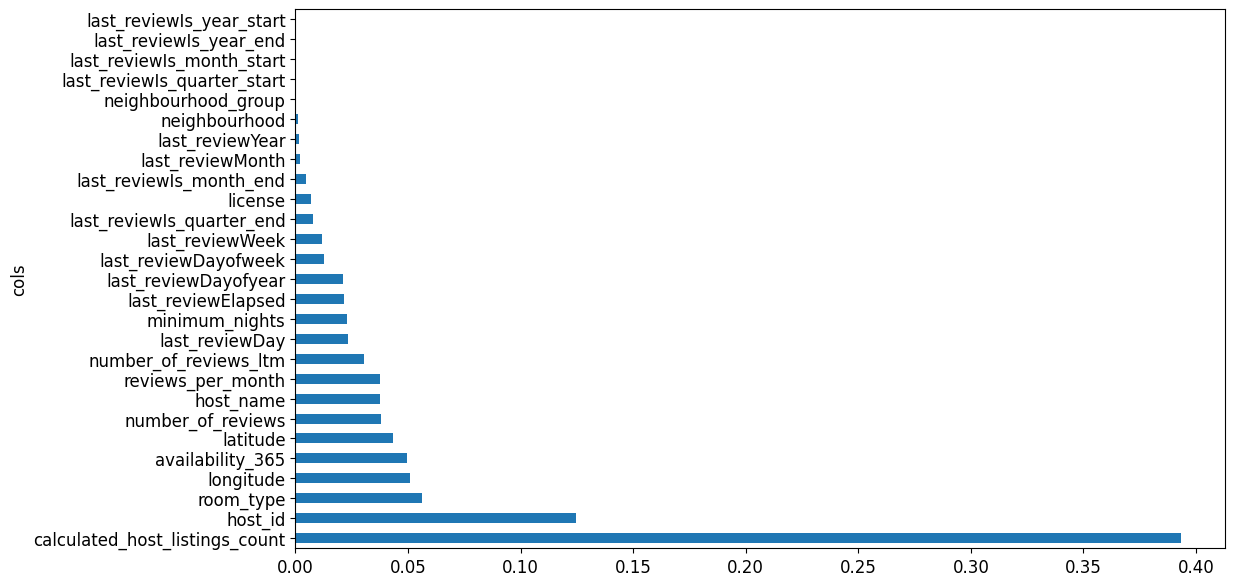

In [107]:
plot_fi(fi[:30])